# PhotoFiTT: Mitotic rounding analysis

Before using this notebook make sure that you have the following: 
  - Mitotic rounding instance segmentation masks: Processed videos using StarDist or any other segmentation method to identify cells in mitotic rounding. It expects `.tif` video files with the instance mask of each identified cell (*i.e.*, the mask of each cell has a different label value).
  - All cells segmentation masks: Processed images (only the first frame of each video) using a segmentation method to identify all the cells in the field of view. It expects `.tif` video files with the instance mask of each identified cell (*i.e.*, the mask of each cell has a different label value)

## Data structure:
- Data (both mitotic rounding masks and all cells masks folders) has to be organised in folders by `replica > illumination condition > light dose`. Alternatively, one could have it for other conditions such as `replica > drug > concentration`. Check the schema as follows.
- Each hierarchical level in the data is encoded as `"Subcategory-XX"` in the code. The Subcategories are used to display the data analysis results. The labels will be identical to the folder name, so the same conditions should always have the same folder name. For example `WL 475 light` folder name for the folders containing data illuminated with a wavelength of 475 nm in replicas 1 and 2. This applies to all the hierarchical levels.
- Alternatively, one could rename these columns using the `pandas dataframe` functionalities in the code.

   ```
   general_path:
    -Masks (folder)
    |
    |--Biological-replica-date-1 (folder) [Subcategory-00]
        |
        |--Cell density / UV Light / WL 475 light [Subcategory-01] 
           |
           |-- control-condition (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition1 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
           |
           |-- condition2 (folder) [Subcategory-02] 
           |    |  file1.tif
           |    |  file2.tif
           |    |  ...
        |
        |--Cell density / UV Light / WL 475 light [Subcategory-01]
        ...
   ```
## Example data
Two types of data are provided to test the notebooks:

- A `csv` file to reproduce the plots and results from our study with synchronised cells. When using this, one should previously add it to the output folder, and then, can skip loading the detected mitotic events (Section 1): indicating the correct paths in Section 0, one can directly jump to Section 2.
- Example data to start using the notebooks from scratch.

## 0. Import all the required dependencies

In [1]:
import photofitt
from photofitt.analysis import count_mitosis_all, quantify_peaks, compare_peaks, total_cell_number, add_inferred_nuclei
from photofitt import display
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### 0.1 Provide some input information
- `masks_path`: The path where the mitotic cells masks are stored. Equivalent to "Masks (folder)" in our hierarchy. This folder should contain all the biological replicas and subsequent folders. For example "/Users/lmorgado/Documents/PhotoFitt test/example-data-github/example-data-notebooks/premitotic_rounding_masks"
- `output_path`: The path where the notebook will save all the results. Once the cell activity is calculated, a CSV file together with the plots will be stored there. For example "/Users/lmorgado/Documents/PhotoFitt test/notebook_test"
- `cellnumber_path`: The path where all the cells in the first frame of each video are segmented. Should also follow the "Masks (folder)" in our hierarchy. For example "/Users/lmorgado/Documents/PhotoFitt test/example-data-github/example-data-notebooks/pix2pix_masks"
- `frame_rate`: The time frame in the videos given in minutes (e.g., one frame every 4 minutes equals `frame_rate = 4`)

In [2]:
masks_path = "/Users/lmorgado/Library/CloudStorage/OneDrive-igc.gulbenkian.pt/Manuscript - PhotoFiTT/PAPER/example-data-github/example-data-notebooks/premitotic_rounding_masks"
output_path =  "/Users/lmorgado/Documents/PhotoFitt test/notebook_test"
cellnumber_path = "/Users/lmorgado/Library/CloudStorage/OneDrive-igc.gulbenkian.pt/Manuscript - PhotoFiTT/PAPER/example-data-github/example-data-notebooks/pix2pix_masks"
frame_rate = 4 # The time gap we will use to compute all the metrics

# Create the folders to store the results
os.makedirs(output_path, exist_ok=True)
os.makedirs(os.path.join(output_path, "plots"), exist_ok=True)

## 1. Count the number of mitoses

In [ ]:
data = count_mitosis_all(masks_path, frame_rate = frame_rate)
# save the information
data.to_csv(os.path.join(output_path, "mitosis_counting.csv"))
print(f"A CSV file with the information about detected mitotic rounding is stored in:")
print(f"{os.path.join(output_path, 'mitosis_counting.csv')}")

### 1.0 Add the total number of cells information and normalise the cell counting

In [ ]:
## Count the number of cells on each FOV
cell_number = total_cell_number(cellnumber_path, type="image")
cell_number.to_csv(os.path.join(output_path, "counting_pix2pix.csv"))
print(f"A CSV file with the number of cells on each FOV is stored in:")
print(f"{os.path.join(output_path, 'counting_pix2pix.csv')}")


### 1.1 Cross the data of mitotic detections and the total number of cells to normalise the information

In [ ]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "mitosis_counting.csv"))
cell_number = pd.read_csv(os.path.join(output_path, 'counting_pix2pix.csv'))
updated_data = add_inferred_nuclei(data, cell_number)

# -----
updated_data["Cell percentage"] = updated_data["Number of cells"] / updated_data['cell_counts_stardist']
data_filtered = updated_data.loc[lambda updated_data: updated_data["Cell percentage"] <= 1] # Remove anny potential frame that was not well segmented
data_filtered.to_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))
print(f"A CSV file with the normalised number of mitotic rounding events on each FOV is stored in:")
print(f"{os.path.join(output_path, 'normalised_mitosis_counting.csv')}")

del updated_data, cell_number, data

## 2. Display detected mitotic rounding events

### 2.1 Display the results per replica and condition

The next code will create different plots with the raw data considering all the conditions and experimental replicas. Use this to identify experimental errors in the acquisitions or biased biological behaviours. This can arise from mechanical malfunctions such as losing the focal plane over the course of the timelapse to cellular stress.

By default, it will export the plots as `.png`, but you can also specify the `graph_format='png'` in the function.

All the plots will be saved in:
/Users/lmorgado/Documents/PhotoFitt test/notebook_test/plots


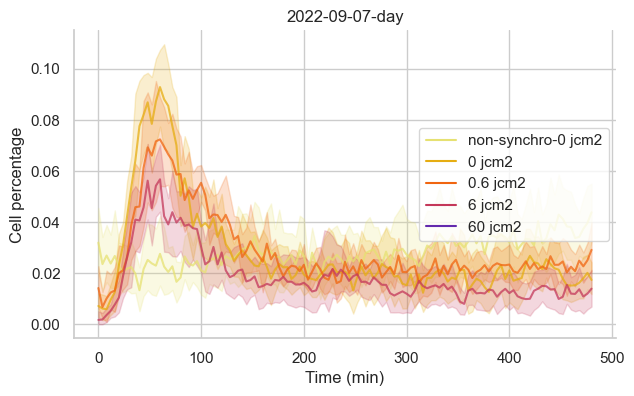

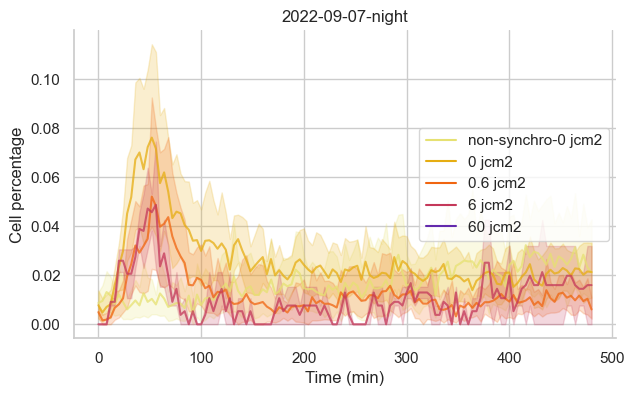

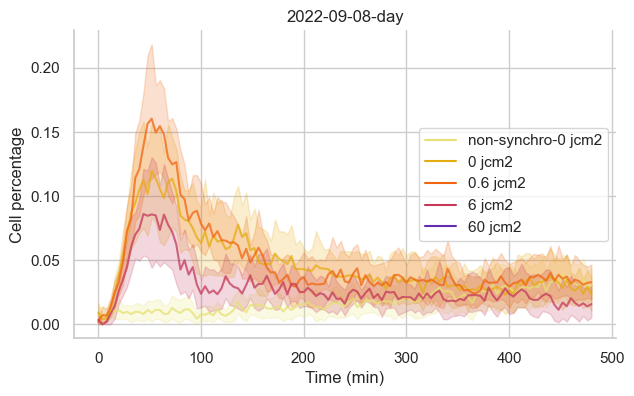

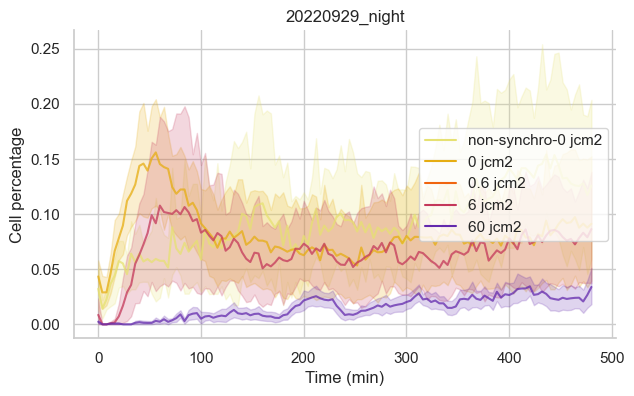

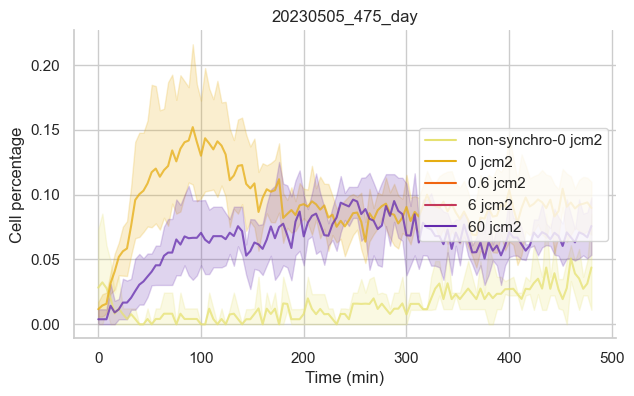

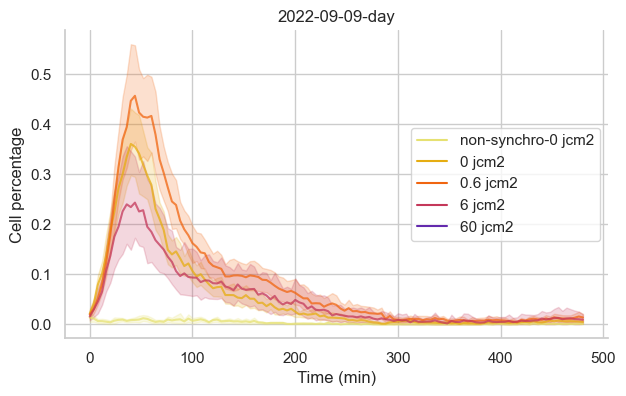

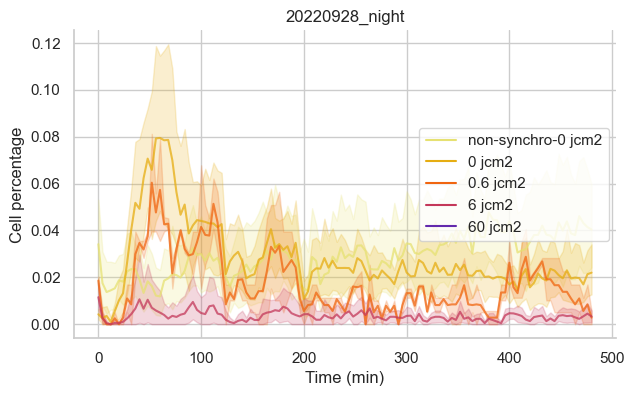

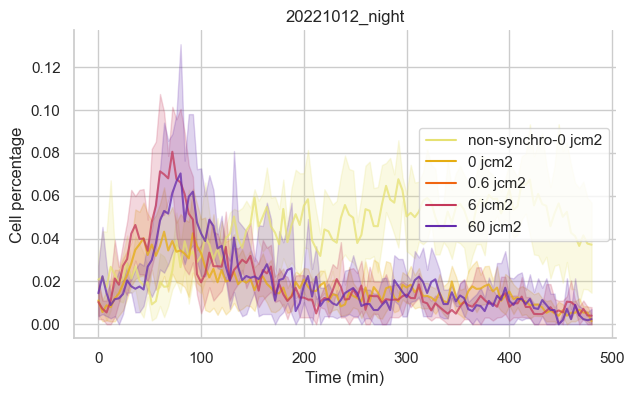

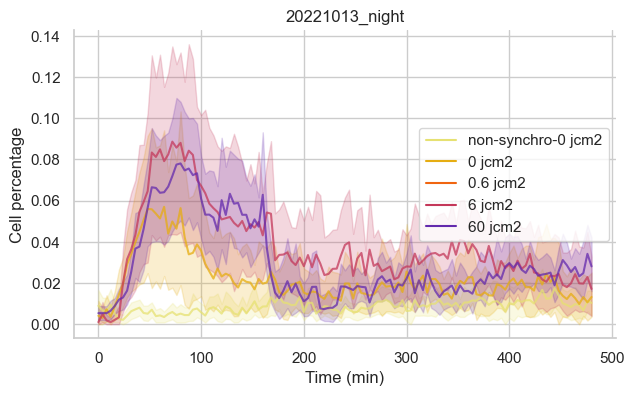

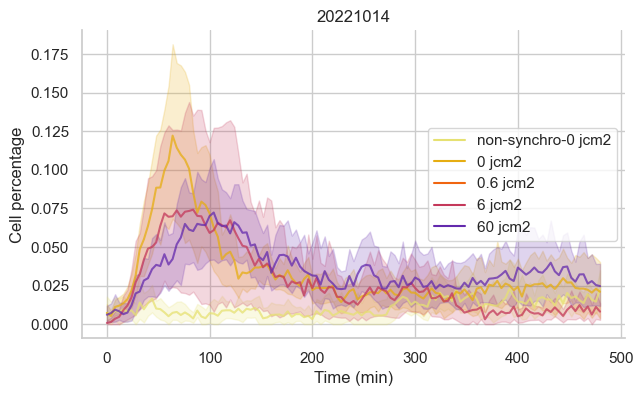

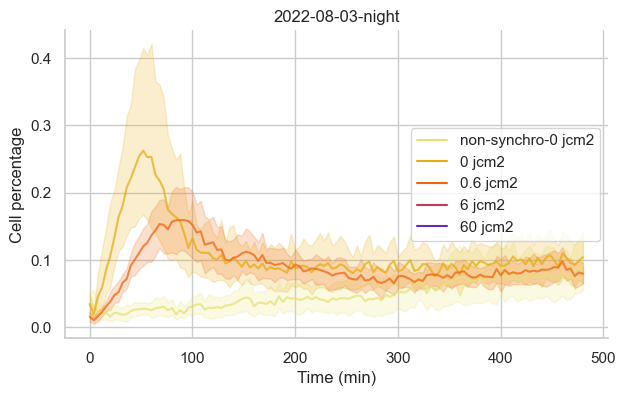

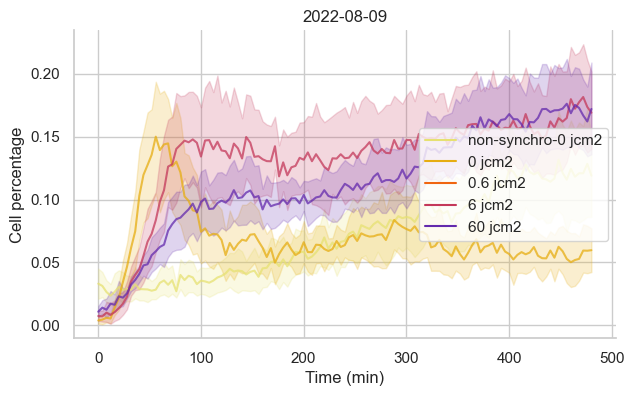

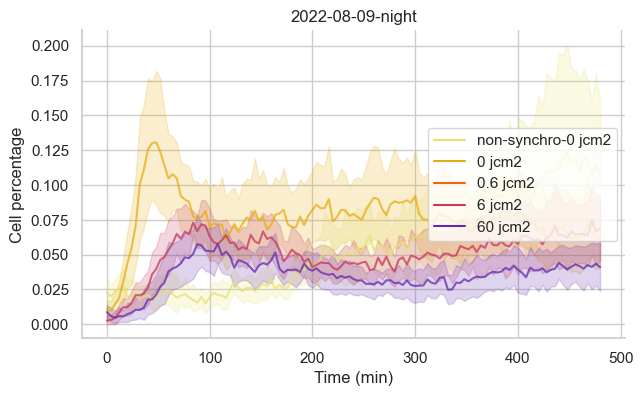

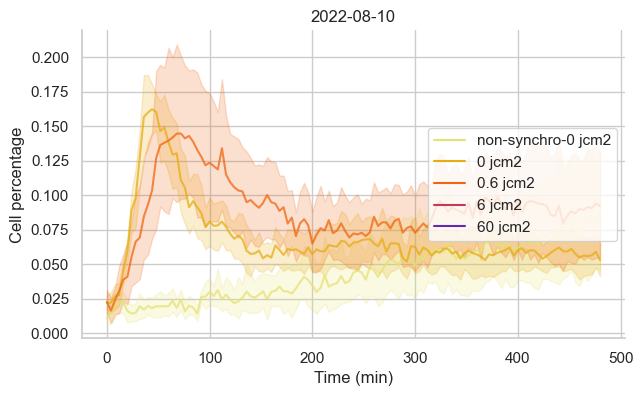

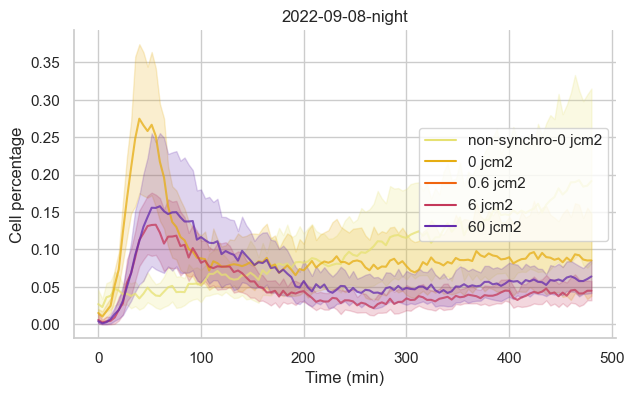

In [3]:
## Load the data
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))
wls = np.unique(data["Subcategory-01"])
condition = "Subcategory-02"

## Name of the variable to display in the plot.
plot_y_var = "Cell percentage"
graph_format = ["png"] #, "pdf"]


hue_order = ['non-synchro-0 jcm2', '0 jcm2', '0.6 jcm2', '6 jcm2','60 jcm2']
print("All the plots will be saved in:")
print(f"{os.path.join(output_path, 'plots')}")

## Colours for the conditions
palette = sns.color_palette("CMRmap_r", len(hue_order)+1) 

for w in wls:
    data_wl = data.loc[lambda data: data["Subcategory-01"]==w]
    groups = np.unique(data_wl["Subcategory-00"])
    for g in groups:
        ploting_data_g = data_wl[data_wl["Subcategory-00"]==g].reset_index(drop=True)  
        for s in ['Raw']:
            ploting_data = ploting_data_g[ploting_data_g["processing"]==s].reset_index(drop=True)    
            title = f"{g}"
            for f in graph_format:
                name = "Synchro_{0}_{1}_{2}_{3}.{4}".format(w, g, plot_y_var, s, f)
                display.conditions(ploting_data,
                                   plot_y_var,
                                   title,
                                   condition,
                                   os.path.join(output_path, "plots"),
                                   name,
                                   hue_order=hue_order,
                                   palette=palette)


### 2.2. Display the results for each single wavelength, including all the conditions. Together and separated.

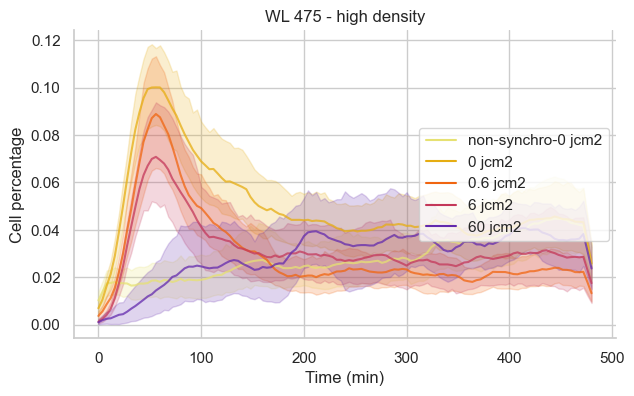

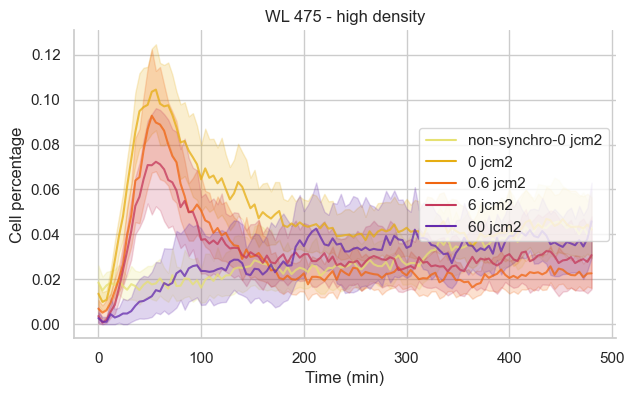

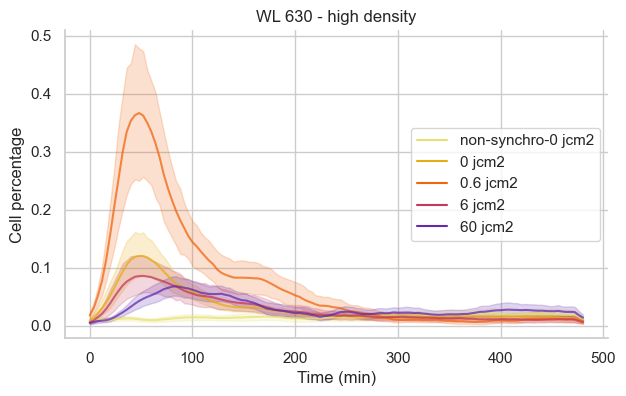

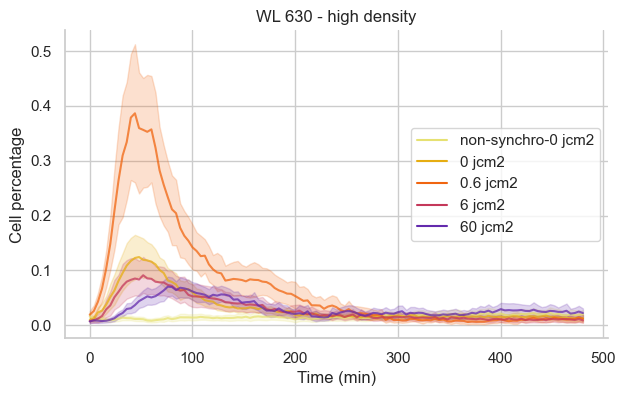

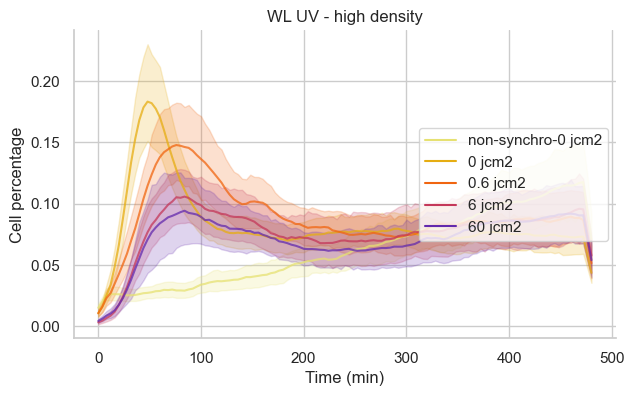

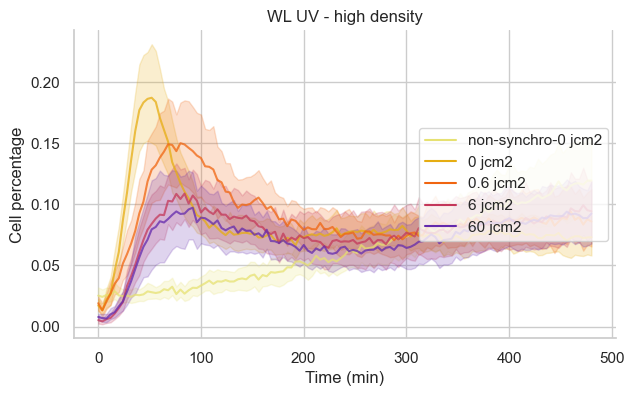

In [4]:
## Indicate the variabled encoding the Wavelength ("Subcategory-01") and light doses ("Subcategory-02").
wls = np.unique(data["Subcategory-01"])
condition = "Subcategory-02"
hue_order = ['non-synchro-0 jcm2', '0 jcm2', '0.6 jcm2', '6 jcm2','60 jcm2']

## There is raw and smooth data. We show the smooth data (with a moving average of kernel 5) for the plots.
smoothing = np.unique(data["processing"])

## Name of the variable to display in the plot.
plot_y_var = "Cell percentage"

## Format to save the plots.
graph_format = ["png"] # "pdf"

## Colours for the conditions
palette = sns.color_palette("CMRmap_r", len(hue_order)+1) # we add one to keep the same ones as before where the unsynchronised control was shown.
for w in wls:
    ploting_data_g = data[data["Subcategory-01"]==w].reset_index(drop=True)  
    
    for s in smoothing:
        # sns.set_style()
        ploting_data = ploting_data_g[ploting_data_g["processing"]==s].reset_index(drop=True)    
        title = f"{w}"
        
        for f in graph_format:
            name = "reduced_{0}_{1}_{2}.{3}".format(w, plot_y_var, s, f)
            display.conditions(ploting_data,
                               plot_y_var,
                               title, condition,
                               os.path.join(output_path, "plots"),
                               name,
                               hue_order=hue_order,
                               palette=palette)


## 3. Calculate the time point with the peak of identified mitotic rounding events

### 3.2. Estimate the mitotic peak and the delay for each video.

In [5]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))
# Only the smooth data is used here to reduce the impact of outliers and noise in the detections.
data = data.loc[lambda data: data["processing"]=='Averaged-kernel5']
# Indicate the variable for which the peak is estimated
plot_y_var = "Cell percentage"
# Quantify temporal peaks of mitosis
data_peaks = quantify_peaks(data,
                            plot_y_var,
                            reference_category='0 jcm2',
                            reference_variable="Subcategory-02",)



## Rename the columns to get the proper naming in the plots
data_peaks = data_peaks.rename(columns={'peak_time': 'Mitotic rounding timepoint (min)', 
                            'delay_synchro': 'Delay w.r.t. synchronised cells (min)',
                           'proportional_delay_synchro': 'Proportional delay w.r.t. synchronised cells'})

#### 3.2.1. Plot the detected delays and mitotic peaks

<Figure size 640x480 with 0 Axes>

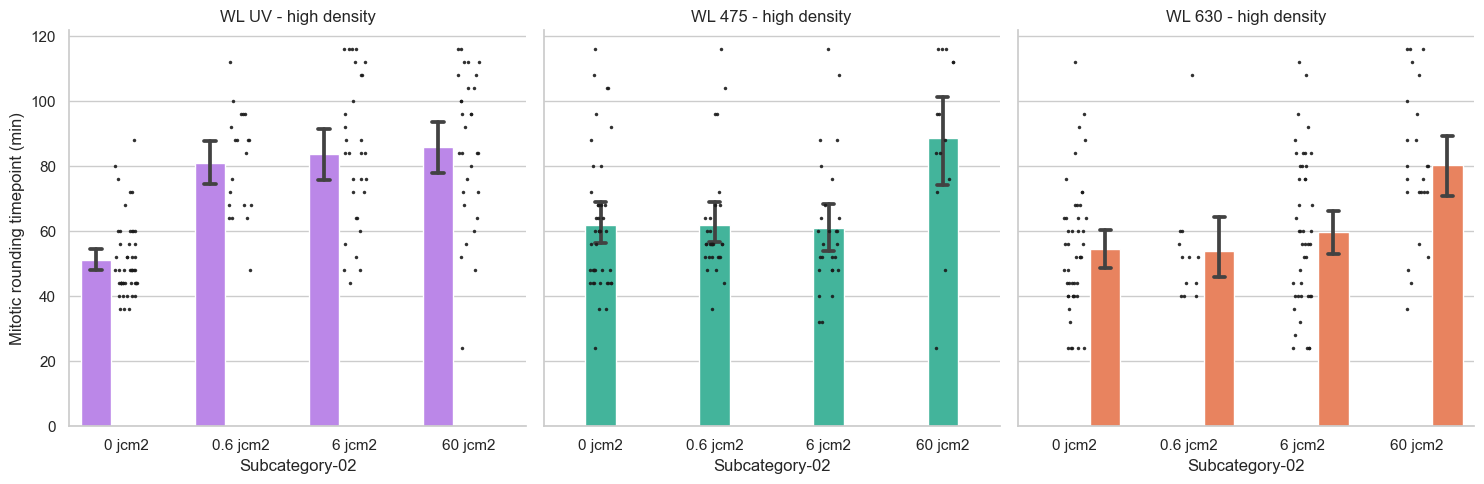

The plots are stored in:
/Users/lmorgado/Documents/PhotoFitt test/notebook_test/plots


In [6]:
x = 'Mitotic rounding timepoint (min)'
graph_format = ["png"] # "pdf"
condition_var = "Subcategory-02"
hue_order = ['0 jcm2', '0.6 jcm2', '6 jcm2','60 jcm2']

columns = "Subcategory-01"
wl_order = ['WL UV - high density', 'WL 475 - high density', 'WL 630 - high density']
palette_colours_columns = ['#BC77F8', '#30C7A6', '#FF7848']

for f in graph_format:        
    # Plot all barplots together
    name = f"{x}.{f}"# name we want to give to the plot
    new_name = f"barplot_all_{name}"
    
    fig = plt.figure()
    g = sns.catplot(
        data_peaks, kind="bar",
        x=condition_var, y=x,
        col=columns,
        hue=columns,
        hue_order = wl_order,
        palette=palette_colours_columns,
        order=hue_order, 
        errorbar=("ci", 95),  capsize=.1,
        col_order=wl_order
    )
    g.map_dataframe(sns.stripplot,
            x=condition_var,
            y=x,
            order=hue_order, 
            jitter=True,
            dodge=False,
            marker='.',
            color="k",
            alpha=0.9)
    g.set_titles("{col_name}")
    g.savefig(os.path.join(output_path, "plots", new_name), format=f, transparent=True)
    plt.show()

print("The plots are stored in:")
print(f"{os.path.join(output_path, 'plots')}")

## 4 Cell size dynamics

Display the changes in the cell size distribution. There are some parameters that may change: 
- `density_ylim`: depending on the number of detections, the densities of the distributions can be higher or lower. It is set by default as `density_ylim=0.20`
- `time_points`: a list displayed in minutes of the acquired timelapse. One can visualise as many points as desired. We set it to observe the mitotic, mitotic and post-mitotic distributions as `time_points = [32, 60, 92, 120]`
- `time_limit`: What is the maximum timing for which these dynamics are displayed. We consider 2 hours enough to visualise the transitions from mother to daughter (`time_limit = 120`). These conditions could change on a case-by-case basis.
- `reduced_hue`: List of conditions. Use it to display data from a smaller set of conditions.

WL 475 - high density
WL 630 - high density
WL UV - high density
All the new cell size data generated as well as the plots are stored in:
/Users/lmorgado/Documents/PhotoFitt test/notebook_test/plots


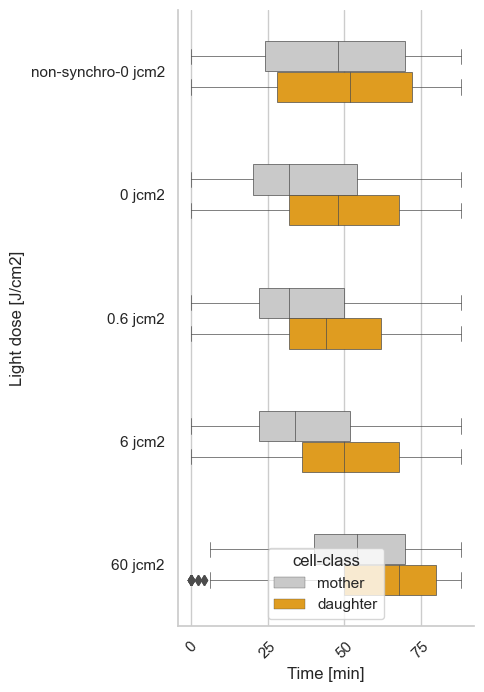

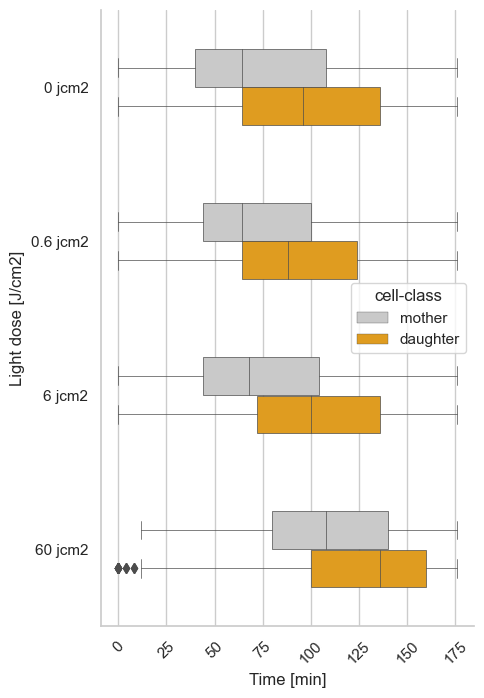

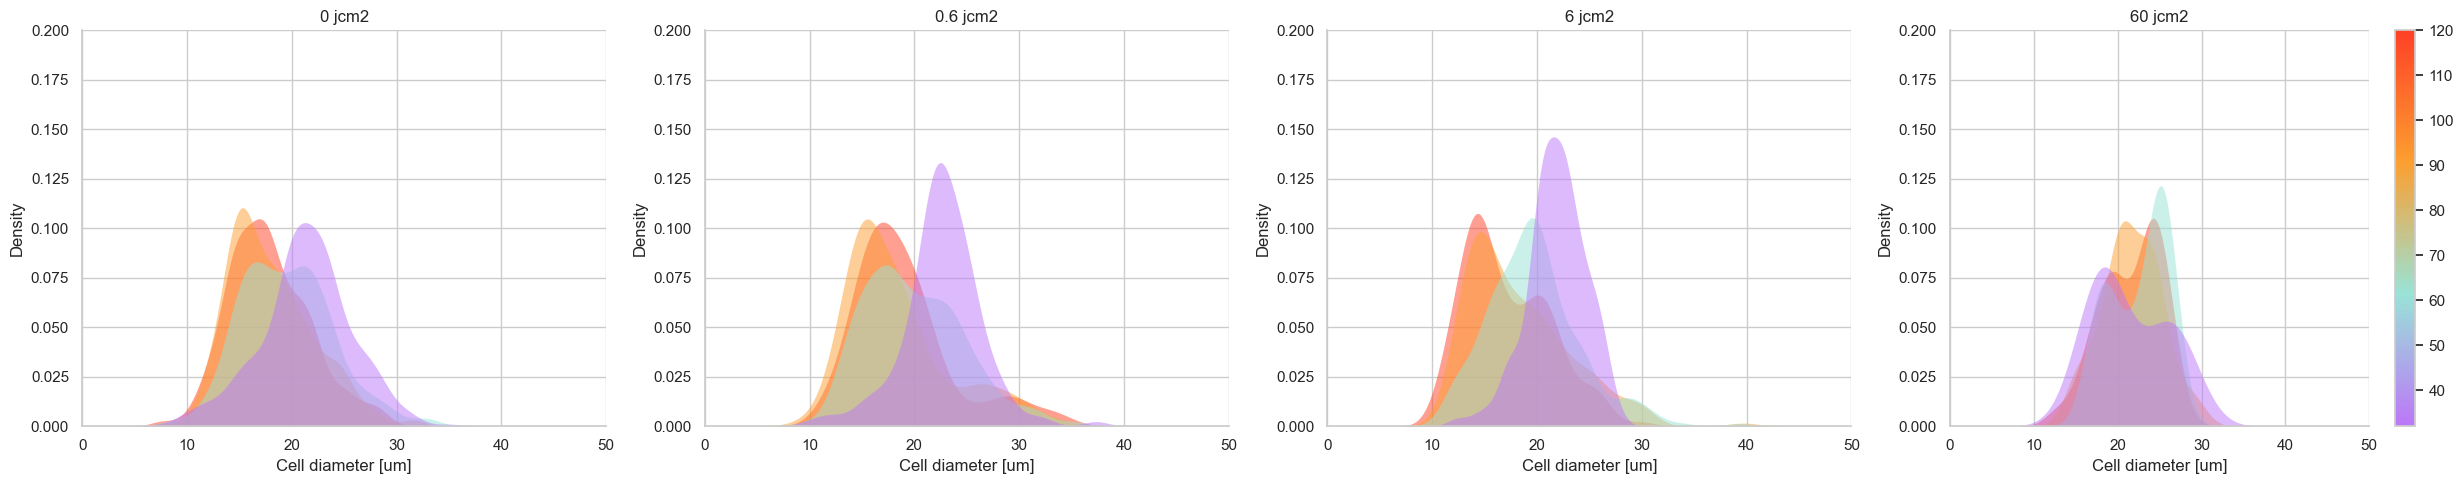

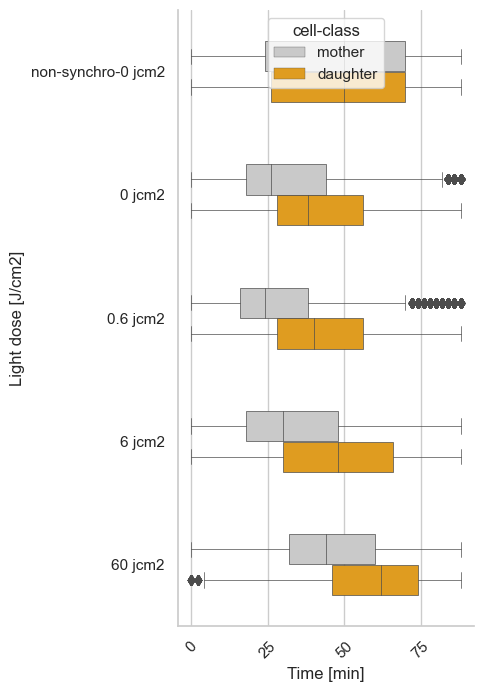

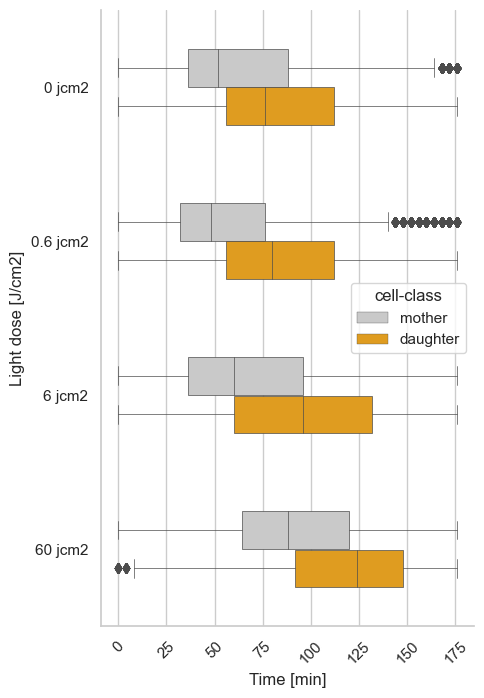

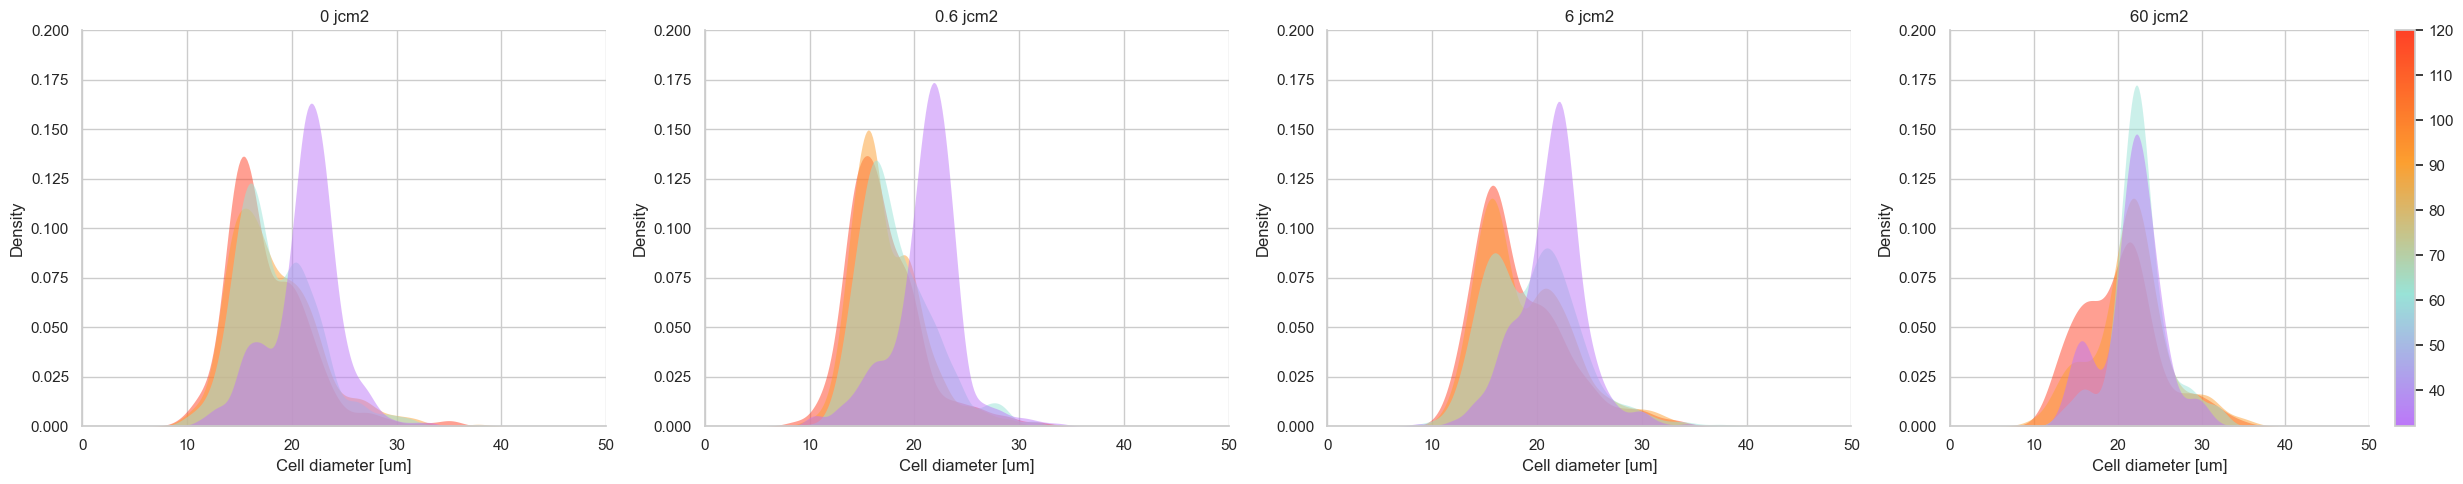

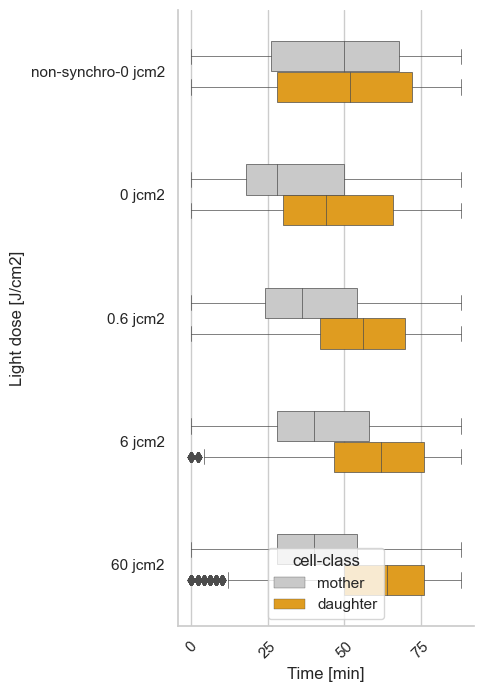

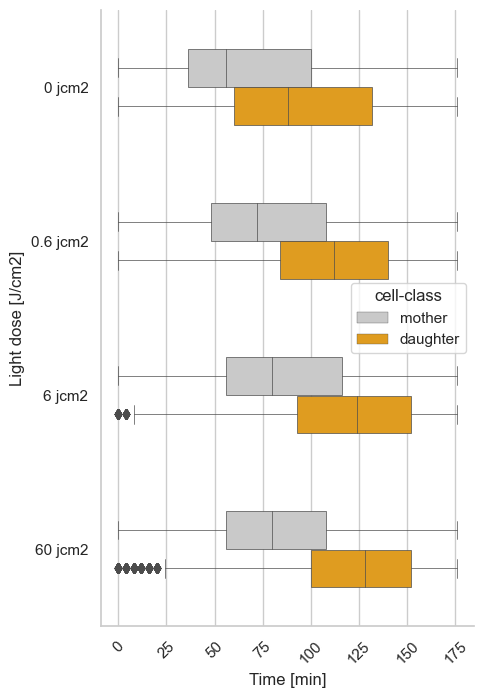

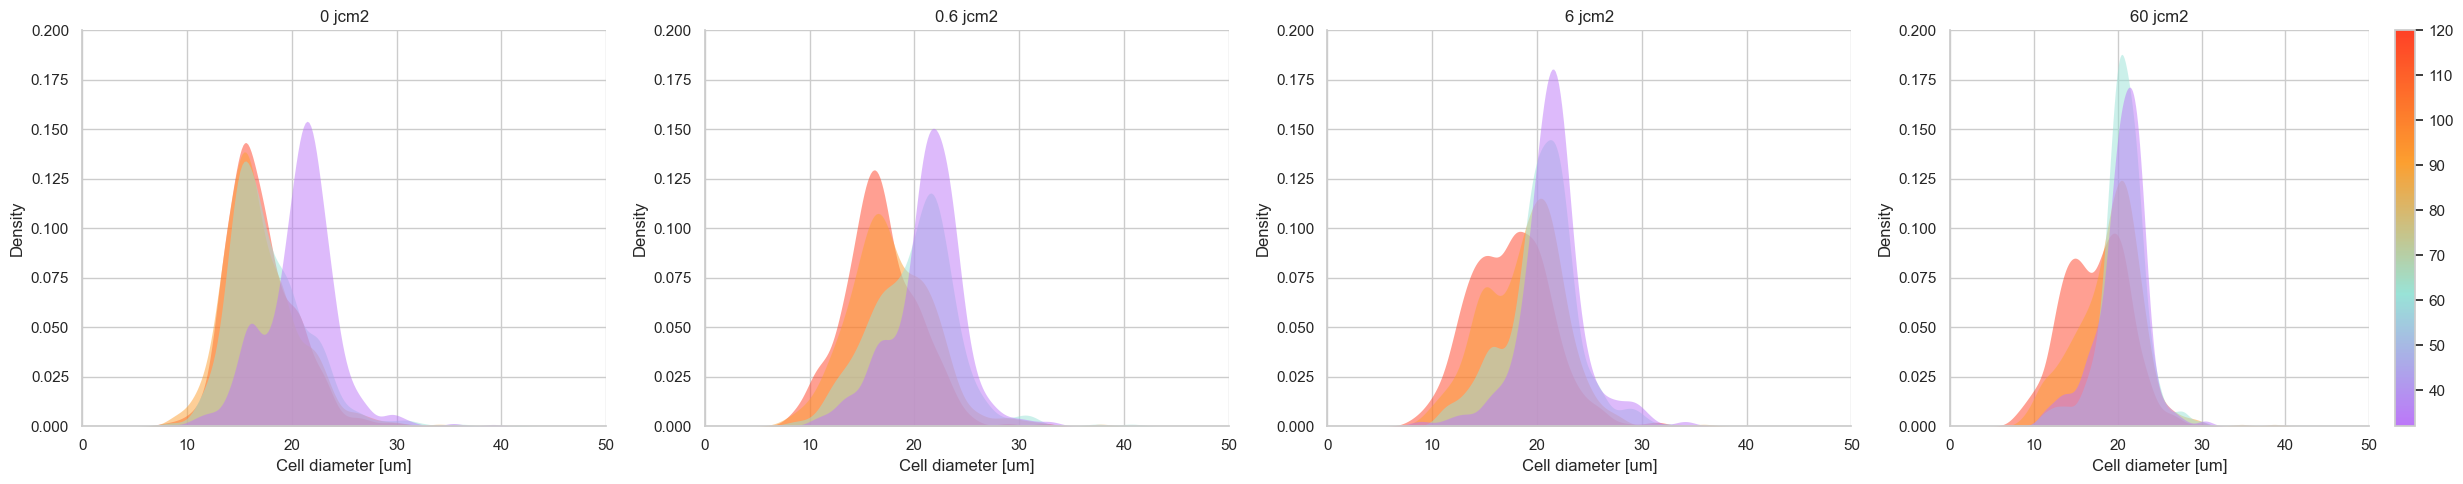

In [7]:
# If you stored the data in a previous session, you can load it again as follows:
data = pd.read_csv(os.path.join(output_path, "normalised_mitosis_counting.csv"))

# Control the order of the legend and the format to export the plots.
# If the order is unknown, let it as huer_order=None
condition = "Subcategory-02"
hue_order = ['non-synchro-0 jcm2', '0 jcm2', '0.6 jcm2', '6 jcm2', '60 jcm2']
colours = ["#BC77F8", "#99E3D7", "#FC9F30", "#FF4126"]

# Additional parameters
density_ylim=0.20
time_points = [32, 60, 92, 120]
time_limit = 120
reduced_hue = ['0 jcm2', '0.6 jcm2', '6 jcm2', '60 jcm2']

# Format to store the plots
graph_format = ['png'] # 'pdf'

for g in graph_format:
    display.cell_size_dynamics(data, os.path.join(output_path, "plots"),
                            condition_var="Subcategory-02",
                            x_label = "Light dose [J/cm2]",
                            graph_format=g,
                            hue_order=hue_order,
                            palette="cool",
                            reduced_hue=reduced_hue,
                            common_norm=False,
                            time_limit=time_limit,
                            time_points=time_points,
                            time_colours=colours,
                            orient="h",
                            density_ylim=density_ylim,
                            xlim=50)
print("All the new cell size data generated as well as the plots are stored in:")
print(f"{os.path.join(output_path, 'plots')}")